In [2]:
import gensim

# Setup nltk corpora path and Pubmed Word2Vec location
pubmed_vec_file = '/Users/timrand/nltk_data/corpora/PubMed-w2v.bin'

In [3]:
model = gensim.models.KeyedVectors.load_word2vec_format(pubmed_vec_file, binary=True)

In [72]:
#given the PubMed-w2v model, we can search for words the most similar to a given word. 
#Interestingly, for molecules, the assocaited words are other molecules
#These proteins/genes are in the same pathway. This is because molecule names are rarely used, 
#but when they are they are in association with each other. Therefore, they have high
#probability of being used near each other and nowhere else--thus a thigh w2v probability. 

TP53_assoc = model.most_similar('TP53' ,topn=50)
TP53_assoc[0:10]

/Users/timrand/anaconda3/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('k-ras', 0.8571987748146057),
 ('CDKN2A', 0.8442618250846863),
 ('KRAS2', 0.8374961614608765),
 ('K-RAS', 0.8317775130271912),
 ('RB1', 0.827904224395752),
 ('Tp53', 0.8247050046920776),
 ('KRAS', 0.8244420289993286),
 ('PIK3CA', 0.82399982213974),
 ('K-ras', 0.8214455842971802),
 ('CTNNB1', 0.8166534900665283)]

In [81]:
#just collect the gene names from the TP_53 list
TP53_assoc = [x[0] for x in TP53_assoc]
TP53_assoc

['k-ras',
 'CDKN2A',
 'KRAS2',
 'K-RAS',
 'RB1',
 'Tp53',
 'KRAS',
 'PIK3CA',
 'K-ras',
 'CTNNB1',
 'FBXW7',
 'CDKN2A/p16',
 'BRAF',
 'HRAS',
 'ARID1A',
 'DPC4',
 'IDH1/IDH2',
 'p16/CDKN2A',
 'CDKN2',
 'CDH1',
 'NRAS',
 'KRAS/BRAF',
 'PTEN/MMAC1',
 'CHEK2',
 'p53-gene',
 'TP73',
 'IDH1/2',
 'BRAF/NRAS',
 'SMAD4',
 'AXIN1',
 'P53',
 'MADH4',
 'p16',
 'N-RAS',
 'K-ras-2',
 'GNAQ',
 'INK4A',
 'CDKN2a',
 'BRAF-V600E',
 'p.R337H',
 'hMLH1',
 'SMARCB1',
 'HRPT2',
 'STK11',
 'BRCA1',
 'hSNF5/INI1',
 'p16/CDKN2',
 'PALB2',
 'Arg(72)Pro',
 'p53']

#### Make a dictionary of this pickle and re-pickle (better version)

In [54]:
import pickle
nomenclature_approved = pickle.load( open( "pickles/nomenclature_approved.pkl", "rb" ) )

#this should be changed to a dictionary for easier lookup
nom_dict = {}
for i,gene in enumerate(nomenclature_approved):
    try:
        nom_dict[gene[0]] = gene[1]
    except:
        print(f'failed on {gene} {i}')

#pickle.dump( nom_dict, open( "nomenclature_approved_dict.pkl", "wb" ) )
print(nom_dict['A2ML1-AS2'])

nomen = pickle.load( open( "nomenclature_approved_dict.pkl", "rb" ) )

****
#### The following function sorts gene names according to lookup result, attempts to rescue gene names by dehyphenating and removing the '/' character often used to designate alternative names.

In [70]:
def bin_approve_fail_notFound(genes):
    """
    bin_fail_notFound() takes a gene string or list of genes and returns the names
    binned into lists in the following order: approve, failed, not found.
    """
    nomen_dict = pickle.load( open( "nomenclature_approved_dict.pkl", "rb" ) )
    
    approved = []
    failed = []
    no_entry = []
    
    #allow single gene lookup as str
    if type(genes) == str:
        genes = [genes]
    
    #include original, dehyphenated, '/'-split versions for lookup
    gene_cleaned=[]
    for _gene in genes:
        _gene = _gene.upper()           #everything in approved list is uppercase
        gene = _gene.replace('-','')   #no hyphens in approved list
        gene = gene.split('/')
        gene_cleaned = gene_cleaned + gene + [_gene]  #process original, dehyphenated-split 
    
    #Should we try to rescue genes with synonym lookup?
    #gene_cleaned + synonym list?
    
    #sort the gene according to lookup result
    for gene in gene_cleaned:
        try:
            approval_status = nomen_dict[gene]
            if approval_status == 1:
                approved.append(gene)
            else:
                failed.append(gene)
        except:
            no_entry.append(gene)
    
    #remove redundancies with set on each list
    approved = list(set(approved))
    failed = list(set(failed))
    no_entry = list(set(no_entry))
    return (approved, failed, no_entry)

    

In [83]:
approved,_,_ = bin_approve_fail_notFound(TP53_assoc)


In [84]:
approved

['SMARCB1',
 'PALB2',
 'ARID1A',
 'CHEK2',
 'STK11',
 'BRAF',
 'NRAS',
 'HRAS',
 'PIK3CA',
 'PTEN',
 'TP73',
 'SMAD4',
 'CTNNB1',
 'BRCA1',
 'IDH2',
 'IDH1',
 'FBXW7',
 'CDKN2A',
 'CDH1',
 'RB1',
 'AXIN1',
 'GNAQ',
 'KRAS',
 'TP53']

#### Make a map of gene/protein names

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
A simple example to create a graphviz dot file and draw a graph.
"""
#    Copyright (C) 2006 by 
#    Aric Hagberg <hagberg@lanl.gov>
#    Dan Schult <dschult@colgate.edu>
#    Manos Renieris, http://www.cs.brown.edu/~er/
#    Distributed with BSD license.     
#    All rights reserved, see LICENSE for details.

from __future__ import absolute_import
from __future__ import unicode_literals
from __future__ import print_function
from __future__ import division

__author__ = """Aric Hagberg (hagberg@lanl.gov)"""

import pygraphviz as pgv                          #1. import pygraphviz as pgv

A=pgv.AGraph()                                    #Create AGraph object

A.add_edge('Dicer1','R2D2')                       #Add edges to molecule name nodes
A.add_edge('Dicer1','Ago1')
A.add_edge('DGCR8','Dicer1')

print(A.string()) # print to screen
print("Wrote simple.dot")
#A.write('simple.dot') # write to simple.dot

A.layout()
file_out = 'TR_RNAi_test.png'
A.draw(file_out)

#B=pgv.AGraph('simple.dot') # create a new graph from file
#B.layout() # layout with default (neato)
#B.draw('simple.png') # draw png
print("Wrote {file_out}")

In [119]:
def molecular_graph(center_molecule, mol_list, file_out='mol_graph.png'):
    import pygraphviz as pgv   
    mol_graph = pgv.AGraph()                         #Create AGraph object

    for mol in mol_list:
        if mol != center_molecule:
            mol_graph.add_edge(center_molecule, mol)     #Add edges to molecule name nodes
    #pgv.node[center_molecules]['fillcolor']='red'
    #mol_graph.attr(overlap='false')
    mol_graph.graph_attr.update(size="20,30")
    mol_graph.layout()
    mol_graph.draw(file_out)    
    

In [120]:
molecular_graph('TP53', approved, file_out='TP53_mol_graph.png')

In [121]:
!open TP53_mol_graph.png

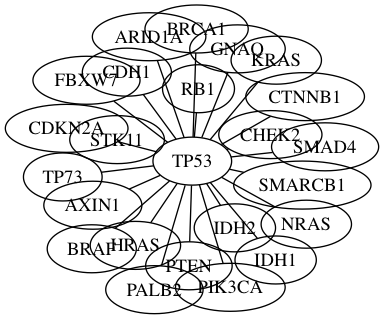